# Phase 1: Exploratory Data Analysis & Preprocessing

In this notebook we will:
1. Load the raw CSVs.  
2. Inspect schema and summary statistics.  
3. Visualize missing values.  
4. Explore distributions & outliers (boxplots, histograms, KDEs).  
5. Generate correlation heatmap.  
6. Plot time-series trends (price, market cap, sentiment).  
7. Save cleaned/interim datasets for Phase 2.

In [ ]:
# Parameters cell for Papermill
DATA_RAW       = "/data/raw"
DATA_INTERIM   = "/data/interim"

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

## 1. Load Raw Data

In [ ]:
coins      = pd.read_csv(f"{DATA_RAW}/coins.csv")
historical = pd.read_csv(f"{DATA_RAW}/historical.csv")
eth_df     = pd.read_csv(f"{DATA_RAW}/eth_df.csv")
ada_df     = pd.read_csv(f"{DATA_RAW}/ada_df.csv")
bnb_df     = pd.read_csv(f"{DATA_RAW}/bnb_df.csv")
btc_df     = pd.read_csv(f"{DATA_RAW}/btc_df.csv")

for name, df in [("coins", coins), ("historical", historical),
                 ("eth_df", eth_df), ("ada_df", ada_df),
                 ("bnb_df", bnb_df), ("btc_df", btc_df)]:
    print(f"{name}.csv → {df.shape} rows×cols")

coins.csv → (8927, 23) rows×cols
historical.csv → (4441972, 19) rows×cols
eth_df.csv → (356, 4) rows×cols
ada_df.csv → (298, 4) rows×cols
bnb_df.csv → (265, 4) rows×cols
btc_df.csv → (332, 4) rows×cols


## 2. Data Overview
Inspect schema, dtypes, and first few rows.

In [3]:
for name, df in [("coins", coins), ("historical", historical), ("eth_df", eth_df)]:
    print(f"### {name.upper()}")
    display(df.info())
    display(df.head())

### COINS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8927 entries, 0 to 8926
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             8927 non-null   int64  
 1   name           8927 non-null   object 
 2   slug           8927 non-null   object 
 3   symbol         8927 non-null   object 
 4   status         8927 non-null   object 
 5   category       8869 non-null   object 
 6   description    8667 non-null   object 
 7   subreddit      2587 non-null   object 
 8   notice         204 non-null    object 
 9   tags           3754 non-null   object 
 10  tag_names      3747 non-null   object 
 11  website        8506 non-null   object 
 12  twitter        7488 non-null   object 
 13  message_board  3684 non-null   object 
 14  chat           6504 non-null   object 
 15  explorer       8453 non-null   object 
 16  reddit         2641 non-null   object 
 17  technical_doc  4165 non-null   object 
 18

None

,id,name,slug,symbol,status,category,description,subreddit,notice,tags,...,message_board,chat,explorer,reddit,technical_doc,source_code,announcement,platform_id,date_added,date_launched
0,1,Bitcoin,bitcoin,BTC,active,coin,## **What Is Bitcoin (BTC)?**\n\nBitcoin is a ...,bitcoin,NaN,"mineable, pow, sha-256, store-of-value, state-...",...,https://bitcointalk.org,NaN,https://blockchain.coinmarketcap.com/chain/bit...,https://reddit.com/r/bitcoin,https://bitcoin.org/bitcoin.pdf,https://github.com/bitcoin/,NaN,NaN,2013-04-28T00:00:00.000Z,NaN
1,2,Litecoin,litecoin,LTC,active,coin,## What Is Litecoin (LTC)?\n\nLitecoin (LTC) i...,litecoin,NaN,"mineable, pow, scrypt, medium-of-exchange, bin...",...,"https://litecointalk.io/, https://litecoin-fou...",https://telegram.me/litecoin,"https://blockchair.com/litecoin, https://chain...",https://reddit.com/r/litecoin,NaN,https://github.com/litecoin-project/litecoin,https://bitcointalk.org/index.php?topic=47417.0,NaN,2013-04-28T00:00:00.000Z,NaN
2,3,Namecoin,namecoin,NMC,active,coin,Namecoin (NMC) is a cryptocurrency . Users are...,namecoin,NaN,"mineable, pow, sha-256, platform",...,NaN,https://telegram.me/namecoin,"https://nmc.tokenview.com/, https://www.namebr...",https://reddit.com/r/namecoin,NaN,https://github.com/namecoin,https://bitcointalk.org/?topic=6017.0,NaN,2013-04-28T00:00:00.000Z,NaN
3,4,Terracoin,terracoin,TRC,active,coin,Terracoin (TRC) launched in 2012 with the aim ...,terracoin,NaN,"mineable, pow, sha-256, masternodes",...,https://medium.com/@clockuniverse,"https://mattermost.terracoin.io/, https://t.me...","https://insight.terracoin.io/, https://explore...",https://reddit.com/r/terracoin,https://wiki.terracoin.io/view/Whitepaper,https://github.com/terracoin,https://bitcointalk.org/index.php?topic=1364146.0,NaN,2013-04-28T00:00:00.000Z,NaN
4,5,Peercoin,peercoin,PPC,active,coin,Peercoin (PPC) is a cryptocurrency . Users are...,peercoin,NaN,"mineable, hybrid-pow-pos, sha-256, medium-of-e...",...,https://talk.peercoin.net,"https://t.me/peercoin, https://discord.gg/m294ReV","https://chainz.cryptoid.info/ppc/, https://exp...",https://reddit.com/r/peercoin,https://docs.peercoin.net/,https://github.com/peercoin,https://bitcointalk.org/index.php?topic=101820.0,NaN,2013-04-28T00:00:00.000Z,NaN


### HISTORICAL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4441972 entries, 0 to 4441971
Data columns (total 19 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   coin_id             int64  
 2   cmc_rank            int64  
 3   market_cap          float64
 4   price               float64
 5   open                float64
 6   high                float64
 7   low                 float64
 8   close               float64
 9   time_high           object 
 10  time_low            object 
 11  volume_24h          float64
 12  percent_change_1h   float64
 13  percent_change_24h  float64
 14  percent_change_7d   float64
 15  circulating_supply  float64
 16  total_supply        float64
 17  max_supply          float64
 18  num_market_pairs    float64
dtypes: float64(14), int64(2), object(3)
memory usage: 643.9+ MB


None

,date,coin_id,cmc_rank,market_cap,price,open,high,low,close,time_high,time_low,volume_24h,percent_change_1h,percent_change_24h,percent_change_7d,circulating_supply,total_supply,max_supply,num_market_pairs
0,2013-04-28,1,1,1.488567e+09,134.210022,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.639231,NaN,NaN,11091325.00,11091325.00,21000000.0,NaN
1,2013-04-28,2,2,7.463702e+07,4.348405,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.799273,NaN,NaN,17164230.00,17164230.00,84000000.0,NaN
2,2013-04-28,5,3,7.250187e+06,0.386525,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.934763,NaN,NaN,18757362.00,18757362.00,NaN,NaN
3,2013-04-28,3,4,5.995997e+06,1.107233,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.050503,NaN,NaN,5415300.00,5415300.00,NaN,NaN
4,2013-04-28,4,5,1.503099e+06,0.646892,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.609159,NaN,NaN,2323569.75,2323569.75,42000000.0,NaN


### ETH_DF
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  356 non-null    int64  
 1   date        356 non-null    object 
 2   count       356 non-null    int64  
 3   normalized  356 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 11.3+ KB


None

,Unnamed: 0,date,count,normalized
0,355,2021-01-04,1,0.527
1,354,2021-01-25,1,0.511
2,353,2021-02-06,1,0.681
3,352,2021-02-10,1,0.422
4,351,2021-02-18,1,0.718


### 2.1 Summary Statistics

In [4]:
for name, df in [("historical", historical), ("eth_df", eth_df)]:
    print(f"{name} describe()")
    display(df.describe().T)

historical describe()


,count,mean,std,min,25%,50%,75%,max
coin_id,4441972.0,3.056184e+03,2.359836e+03,1.000000e+00,1.291000e+03,2.549000e+03,3.995000e+03,1.112300e+04
cmc_rank,4441972.0,1.331714e+03,1.160319e+03,1.000000e+00,4.130000e+02,1.027000e+03,1.928000e+03,5.893000e+03
market_cap,3900714.0,3.756089e+10,2.815395e+13,-1.414391e+09,1.152741e+04,3.041673e+05,3.931232e+06,2.506329e+16
price,4441972.0,2.255646e+05,5.479095e+07,0.000000e+00,1.011897e-03,1.142730e-02,1.570000e-01,1.513989e+10
open,4399423.0,2.235249e+05,5.455108e+07,0.000000e+00,1.018021e-03,1.144760e-02,1.571756e-01,1.514668e+10
high,4399423.0,2.320260e+05,5.587094e+07,0.000000e+00,1.152043e-03,1.279269e-02,1.731046e-01,1.539028e+10
low,4399423.0,2.118747e+05,5.319613e+07,-1.755600e-04,8.973059e-04,1.021394e-02,1.425240e-01,1.492736e+10
close,4399423.0,2.258934e+05,5.491723e+07,0.000000e+00,1.015235e-03,1.141340e-02,1.567196e-01,1.513989e+10
volume_24h,4441972.0,6.657222e+08,9.462810e+11,0.000000e+00,3.288402e+01,3.487587e+03,1.309907e+05,1.410296e+15
percent_change_1h,4437500.0,5.946106e+00,6.619474e+03,-1.000000e+02,-4.448382e-01,2.842170e-14,4.974540e-01,1.172576e+07


eth_df describe()


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,356.0,177.500000,102.912584,0.00,88.7500,177.50000,266.250000,355.000
count,356.0,23.671348,18.005519,1.00,8.0000,22.00000,34.000000,87.000
normalized,356.0,0.316667,0.262326,-0.95,0.1532,0.33175,0.482475,0.995


## 3. Missing-Value Visualization
Use `missingno` to see where data is missing.

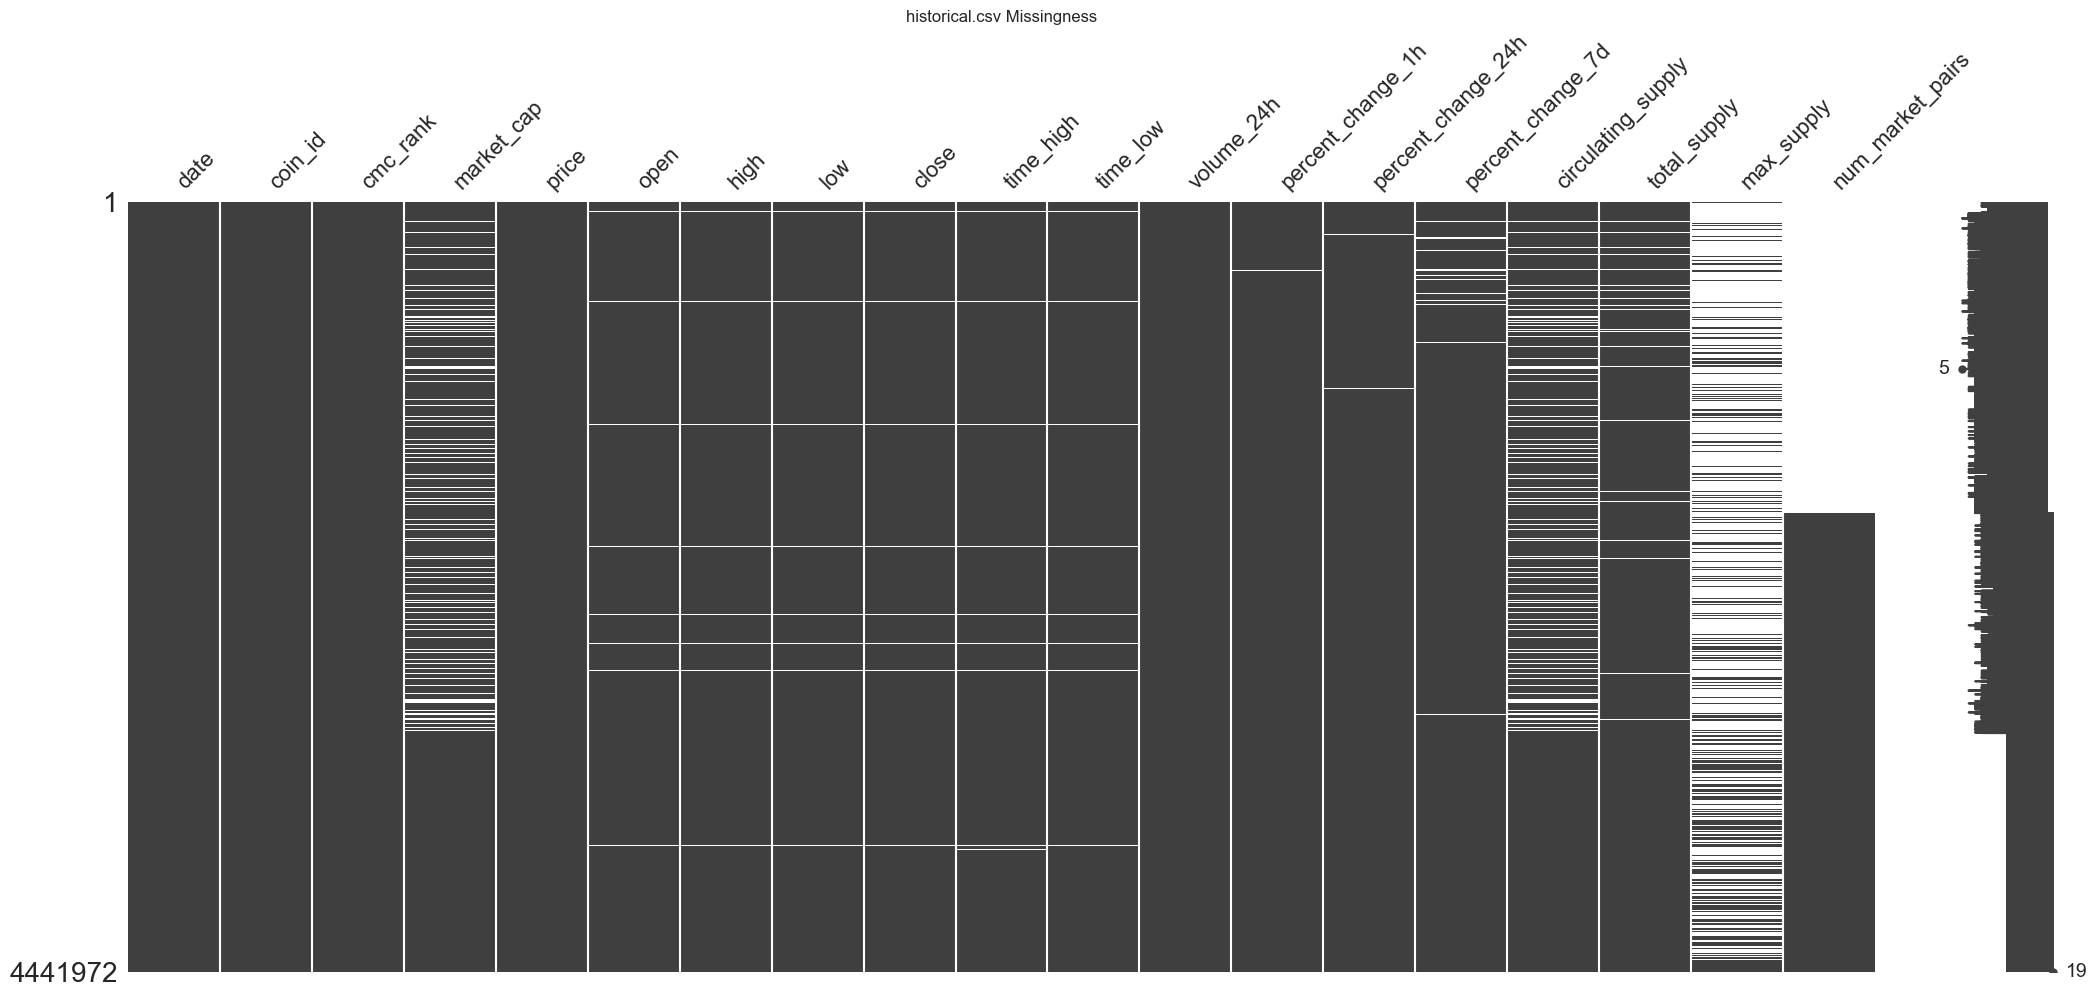

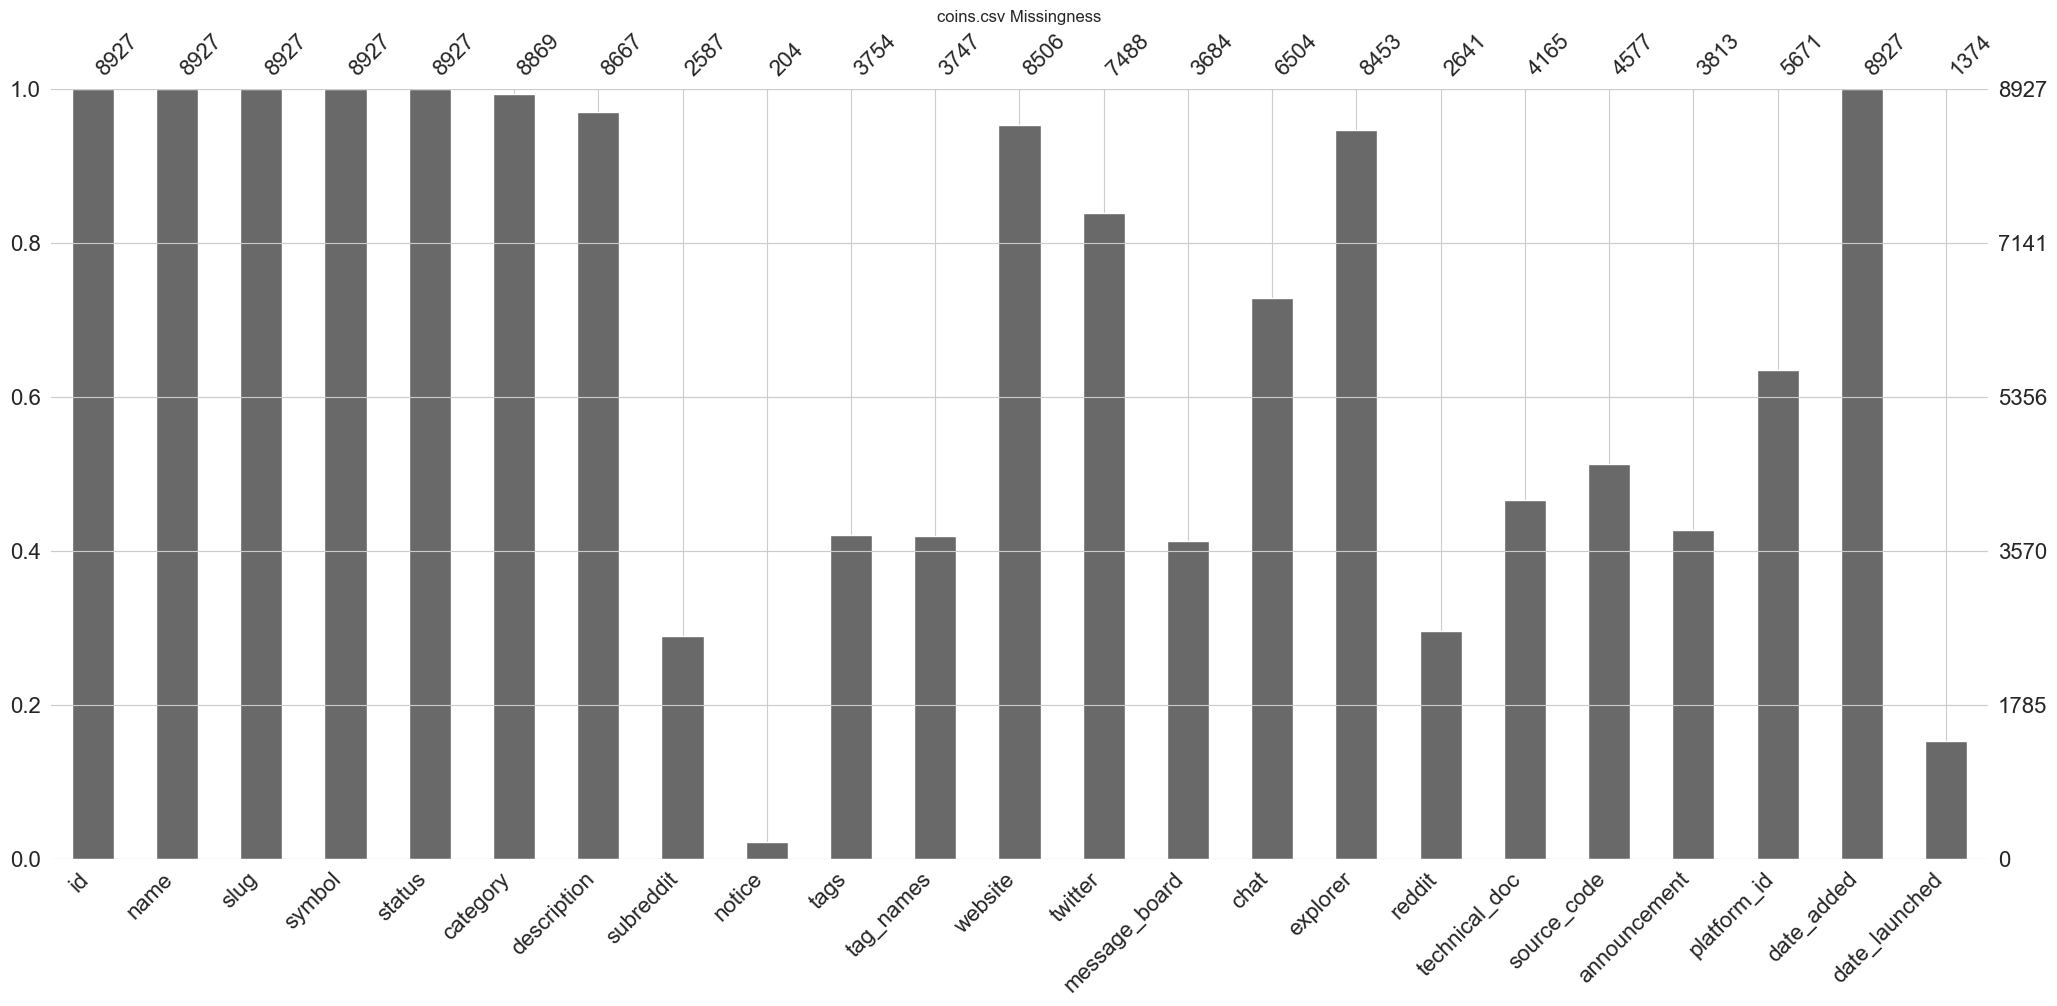

In [5]:
msno.matrix(historical); plt.title("historical.csv Missingness")
plt.show()

msno.bar(coins); plt.title("coins.csv Missingness")
plt.show()

## 4. Distribution Plots (Histograms & KDE)
Loop through all numeric columns in `historical` to see distributions.

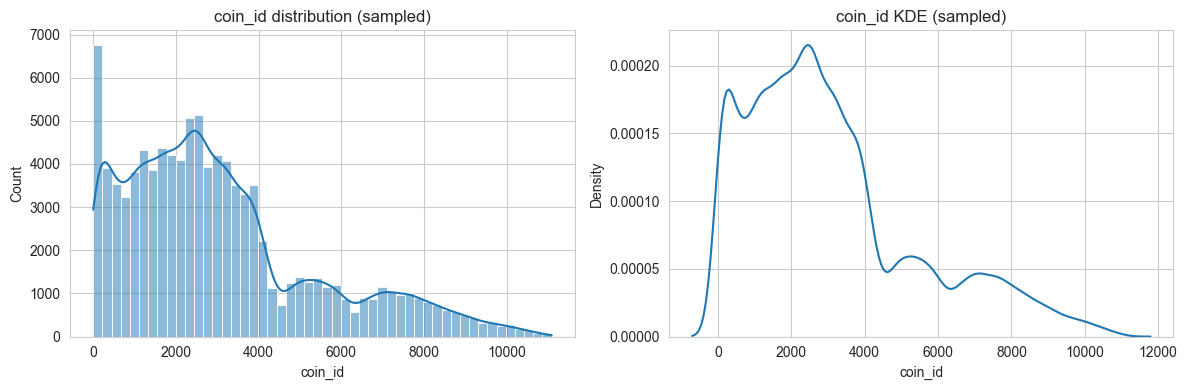

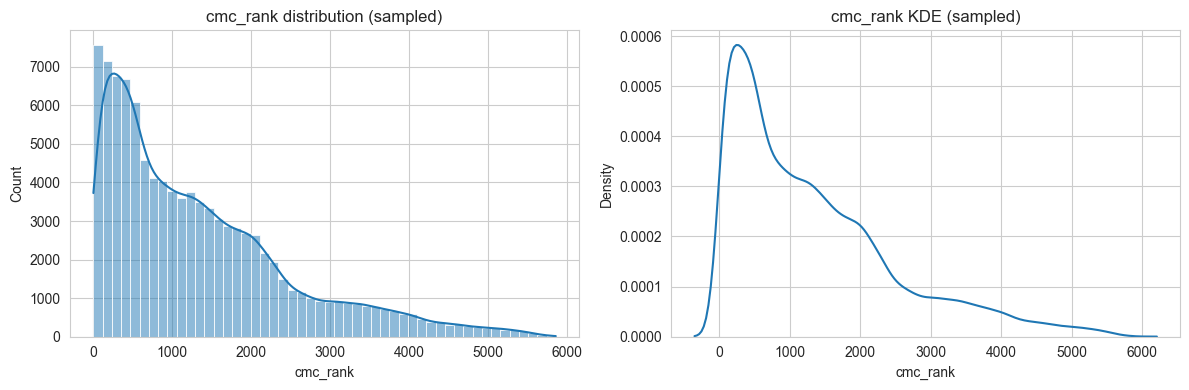

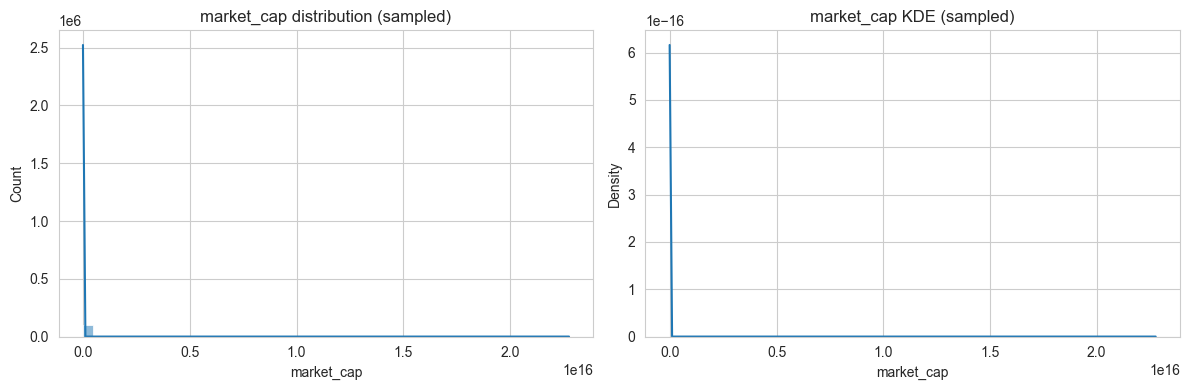

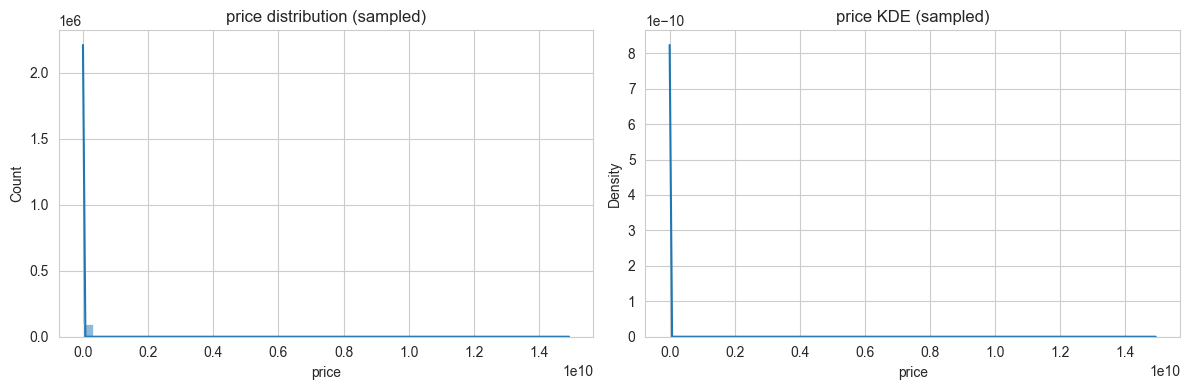

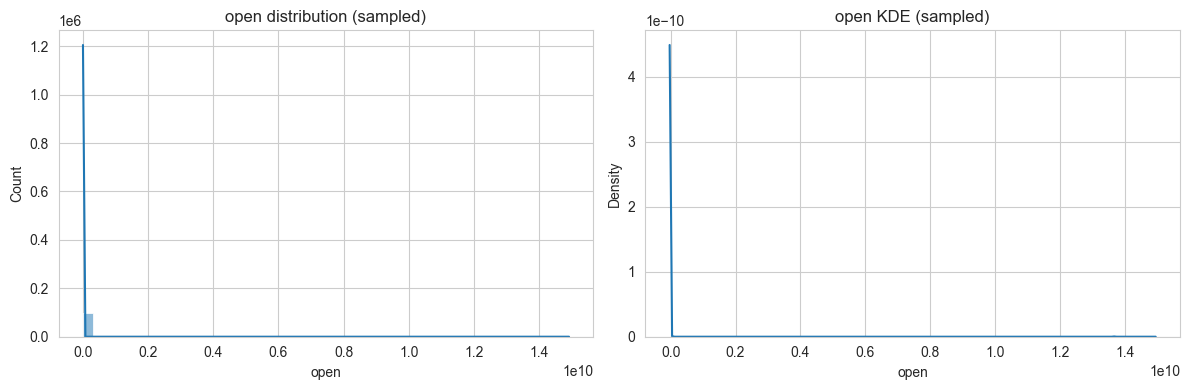

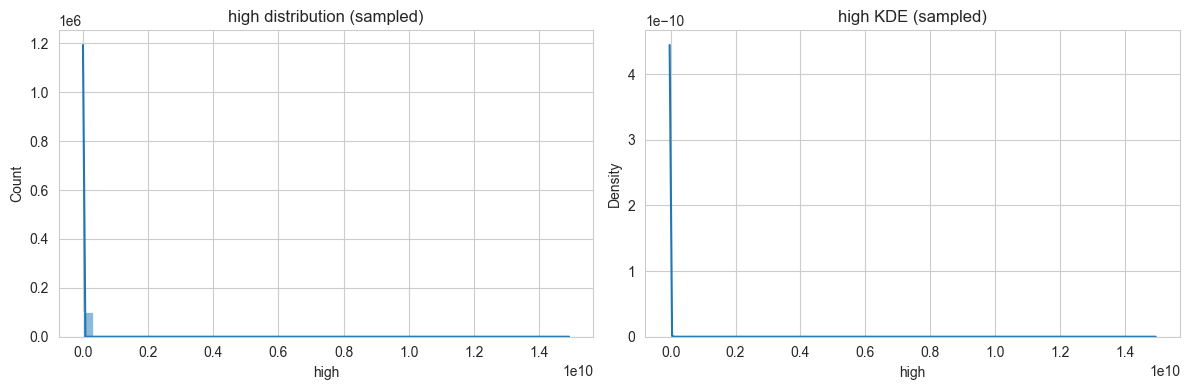

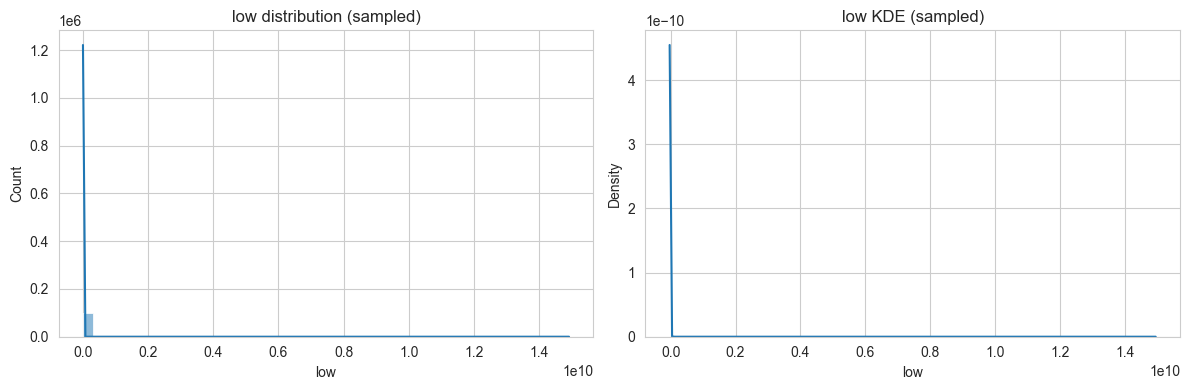

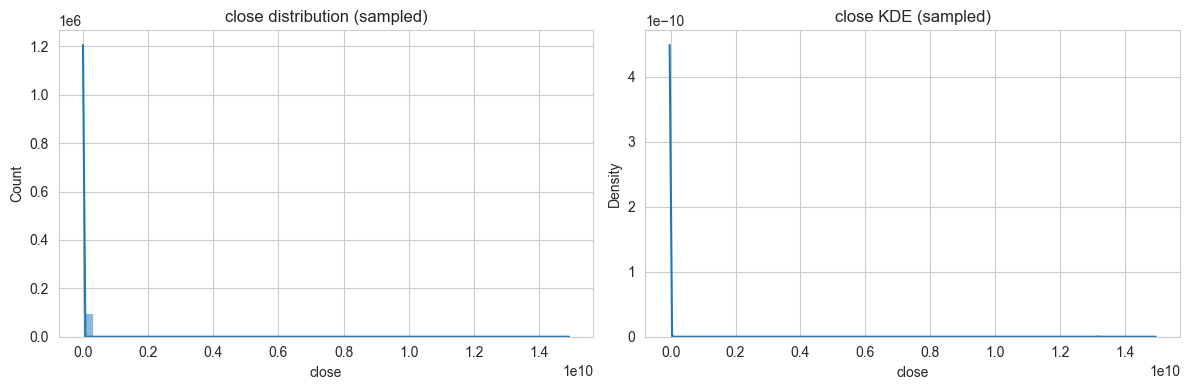

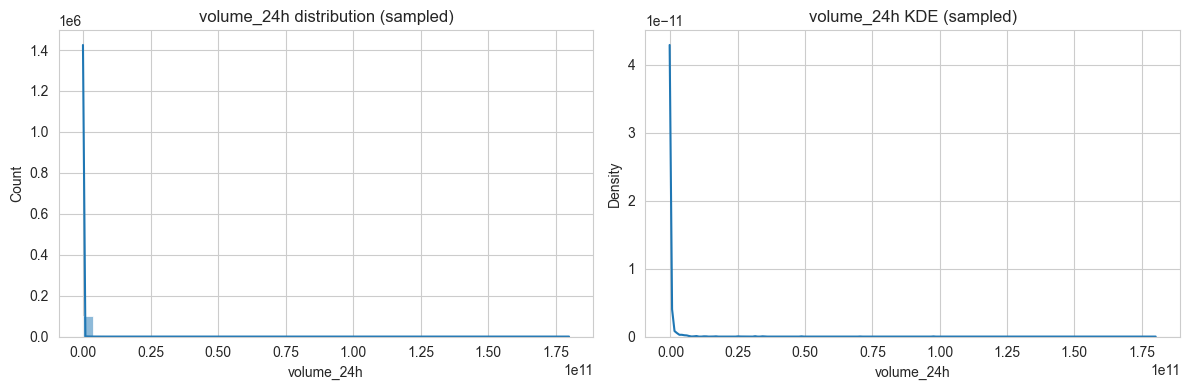

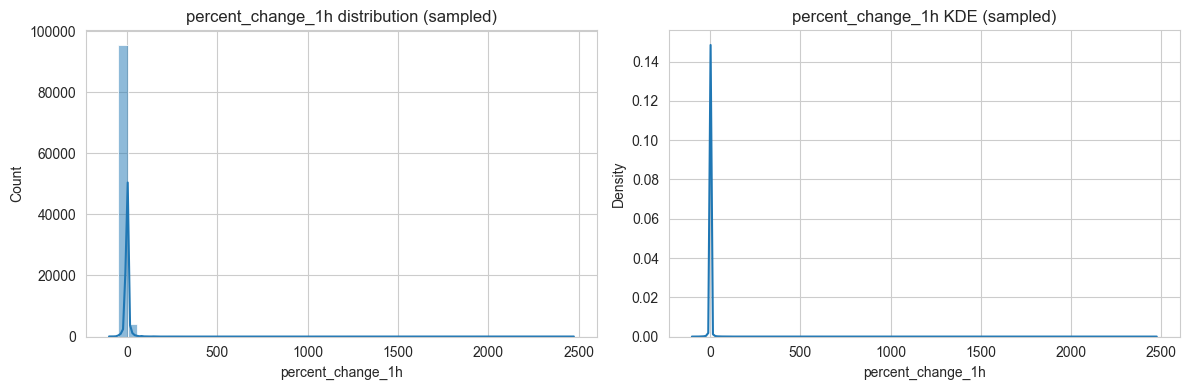

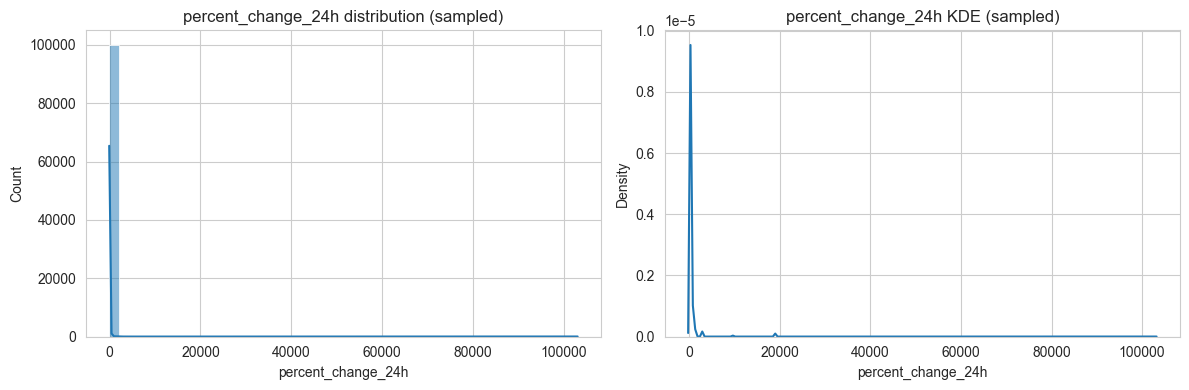

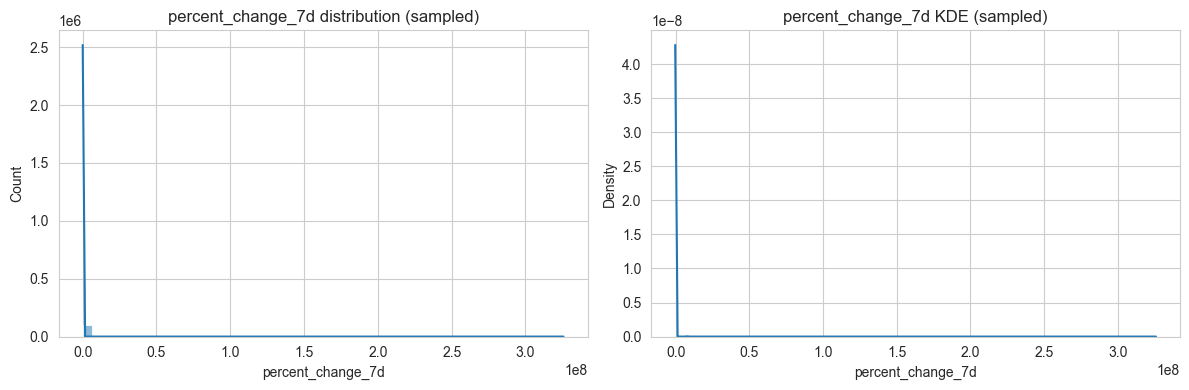

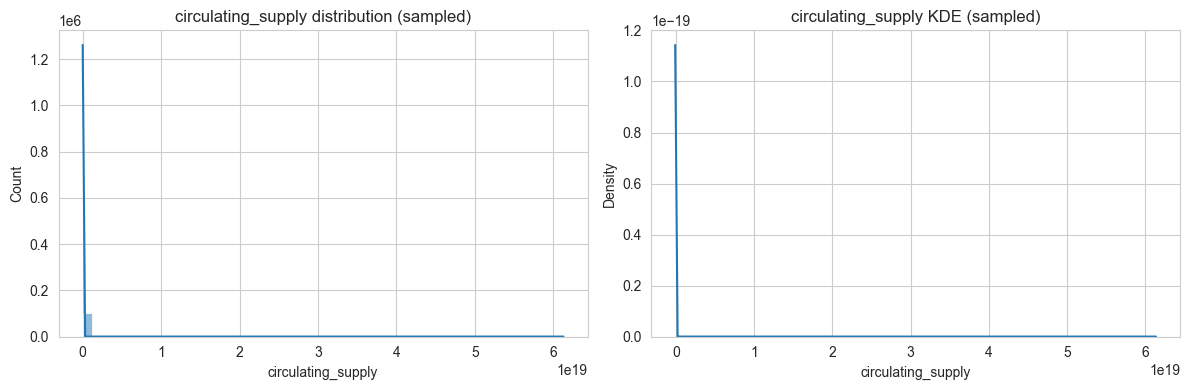

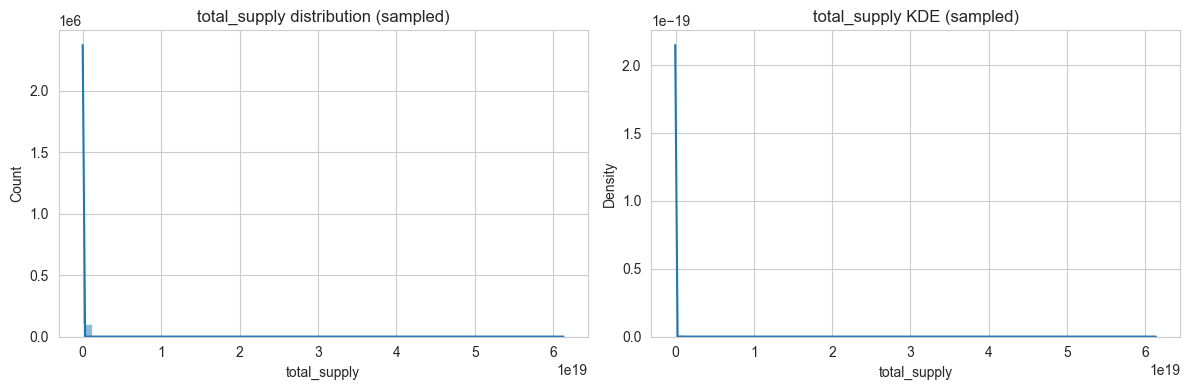

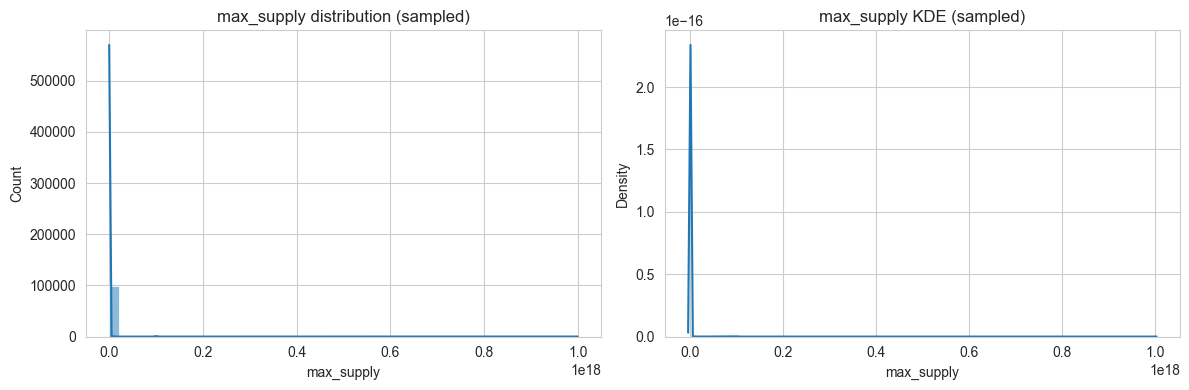

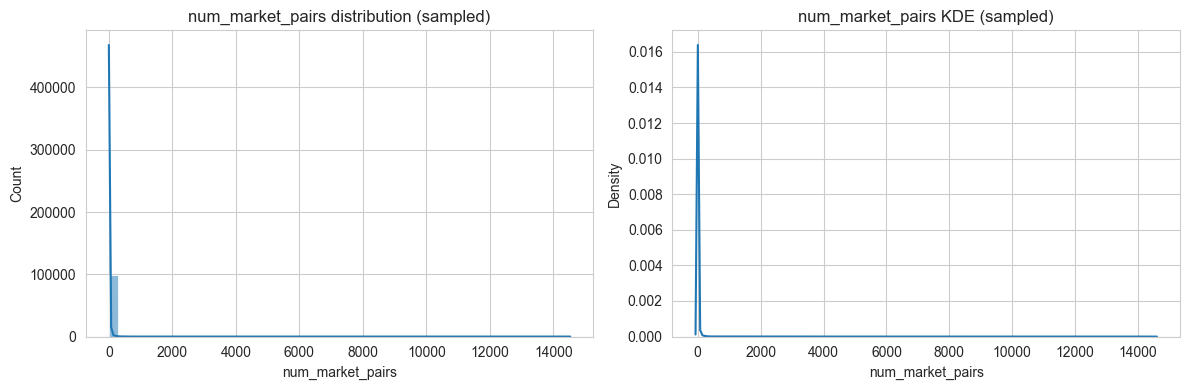

In [6]:
# Updated distribution plots with subsampling and fixed bins
num_cols = historical.select_dtypes(include="number").columns

for col in num_cols:
    # 1) Drop NAs
    data = historical[col].dropna()
    
    # 2) Subsample if too large
    if len(data) > 100_000:
        data = data.sample(100_000, random_state=42)
    
    # 3) Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.histplot(
        data,
        bins=50,            # fixed number of bins
        kde=True,
        ax=axes[0]
    ).set_title(f"{col} distribution (sampled)")
    
    sns.kdeplot(
        data,
        bw_adjust=1,        # default bandwidth
        ax=axes[1]
    ).set_title(f"{col} KDE (sampled)")
    
    # 4) (Optional) Log‐scale if distribution is extremely skewed
    # axes[0].set_xscale('log')
    # axes[1].set_xscale('log')
    
    plt.tight_layout()
    plt.show()

## 5. Outlier Detection via Boxplots
Boxplots for the same numeric columns.

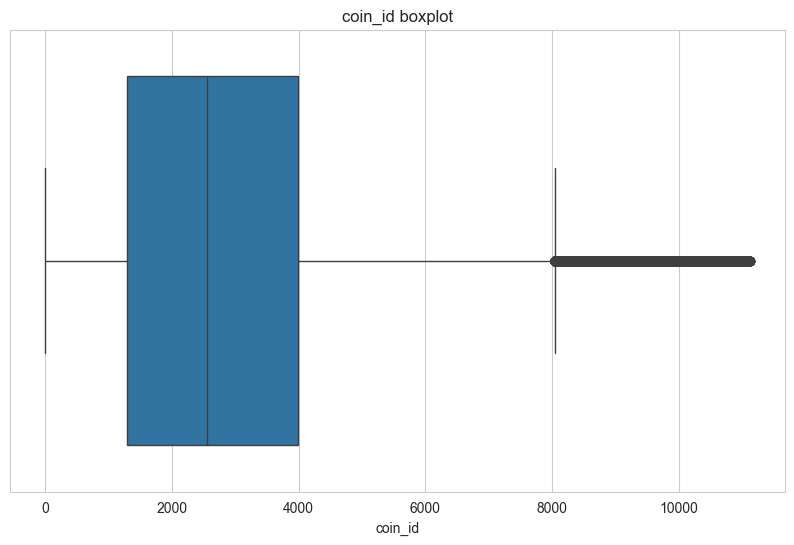

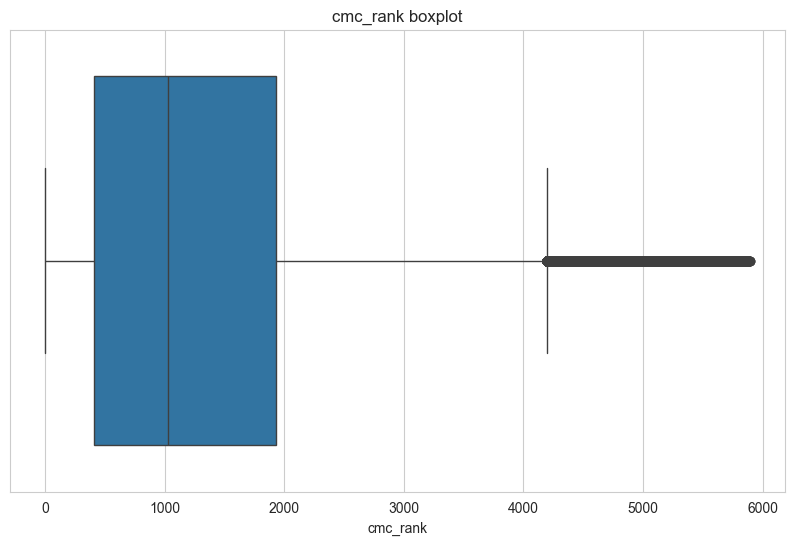

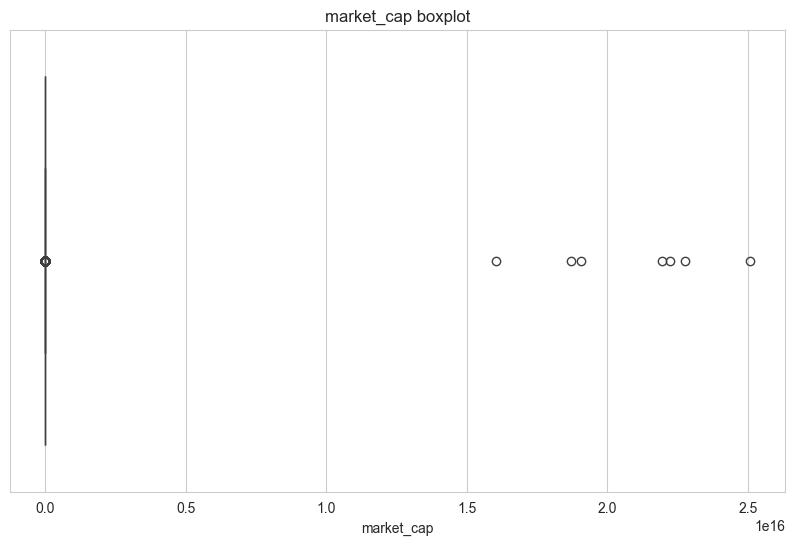

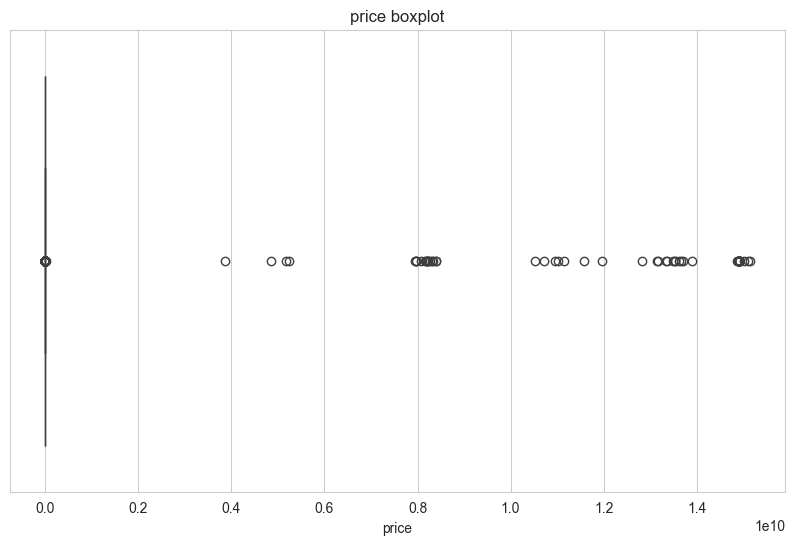

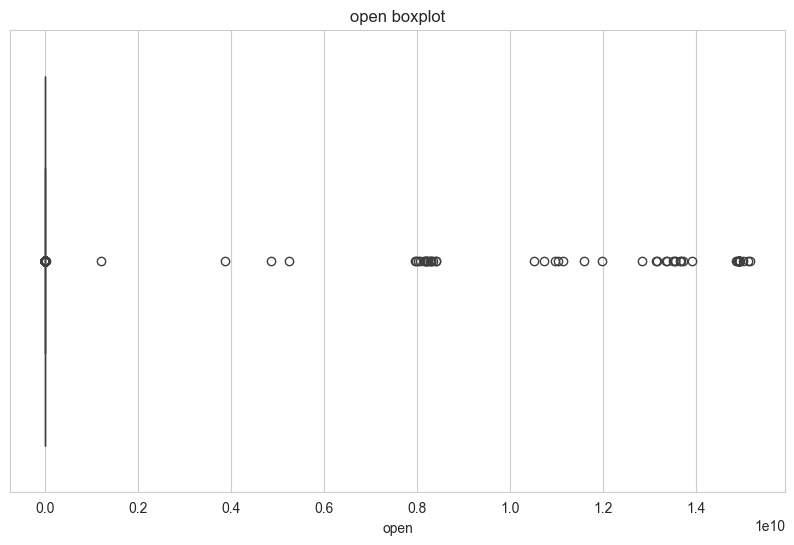

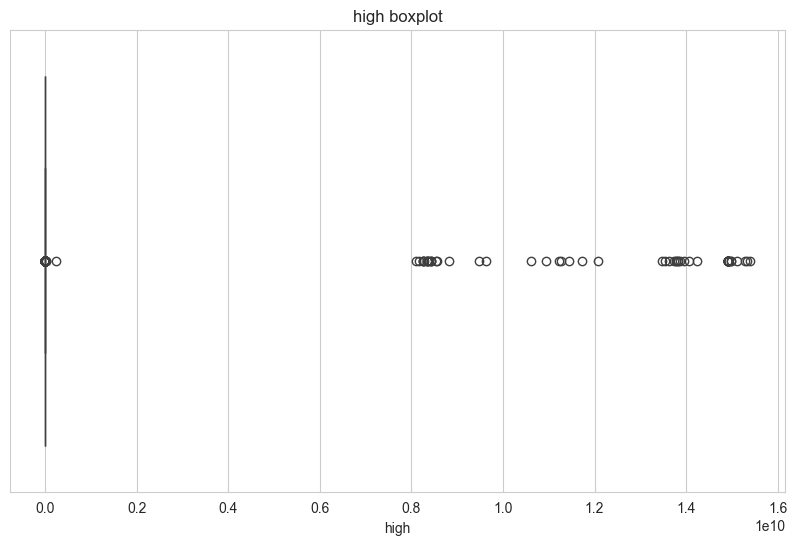

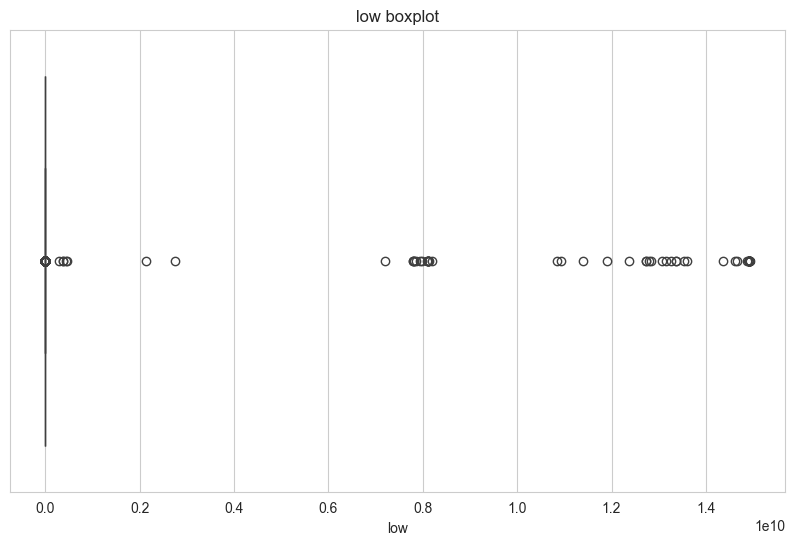

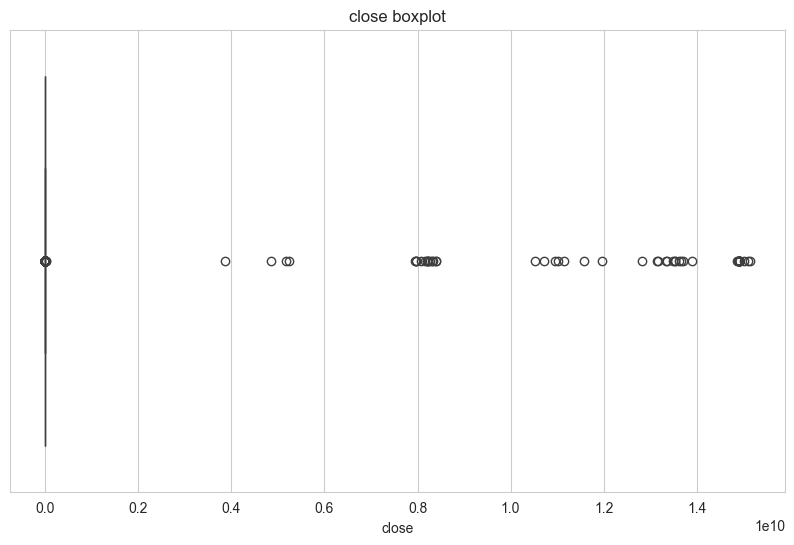

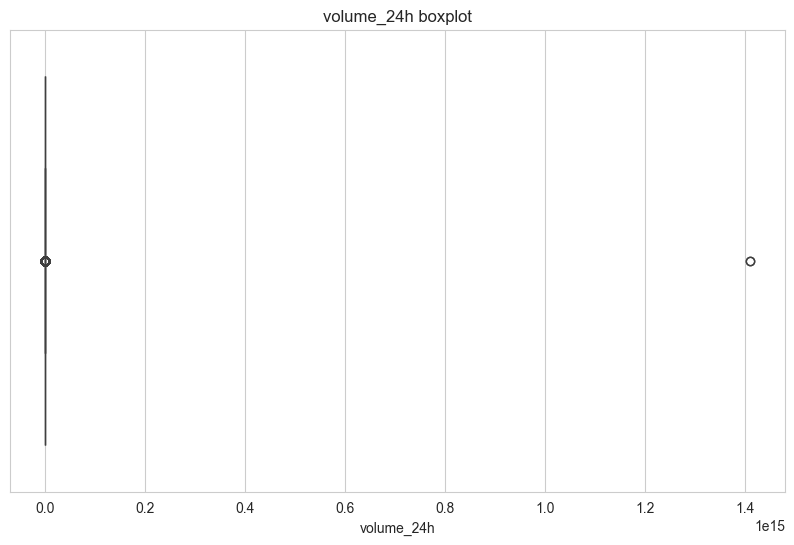

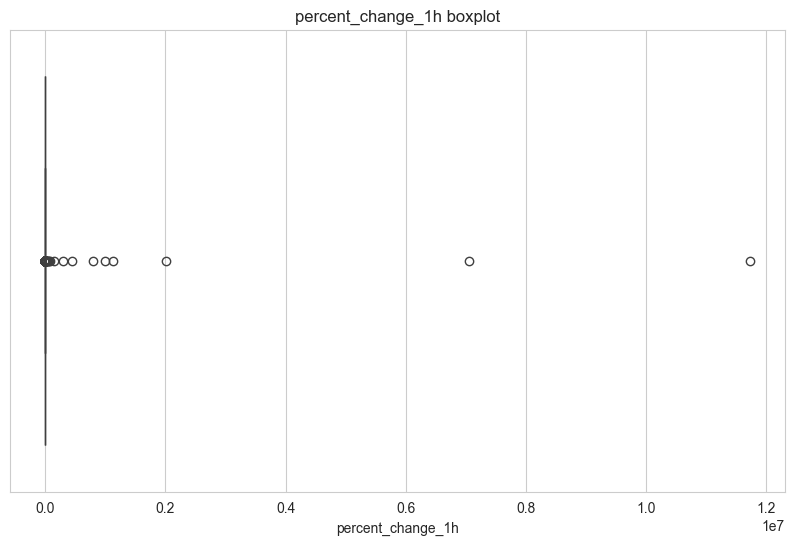

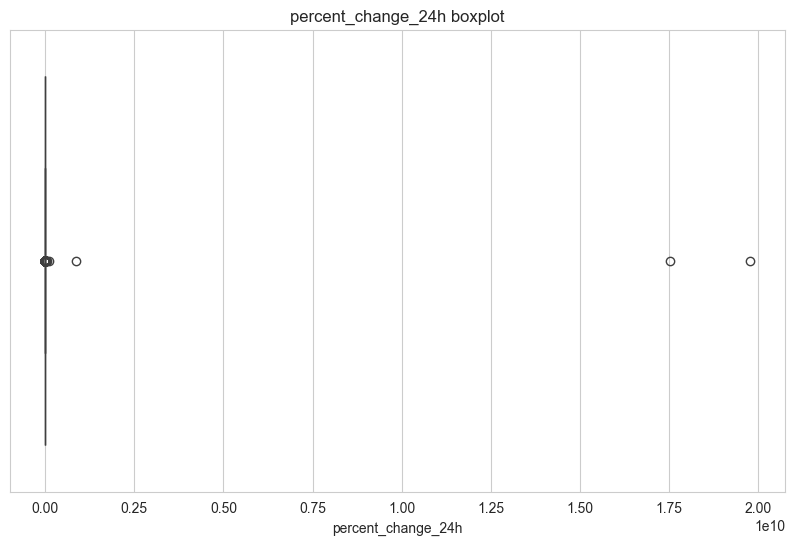

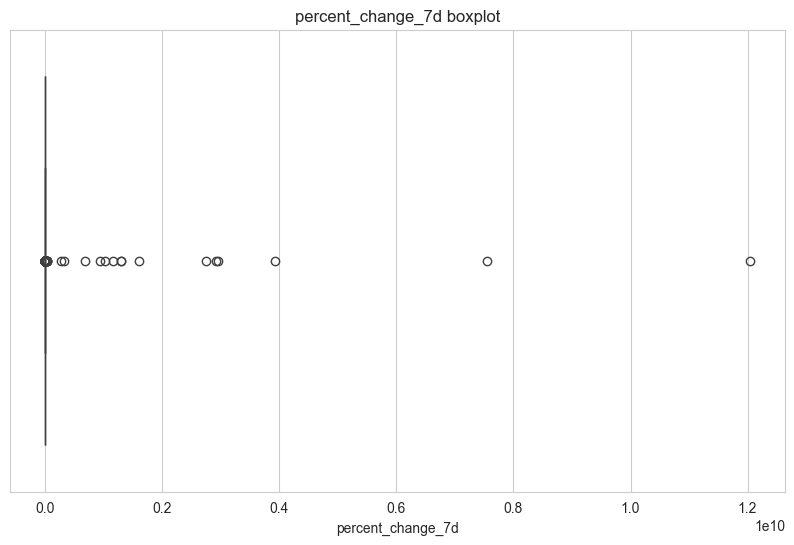

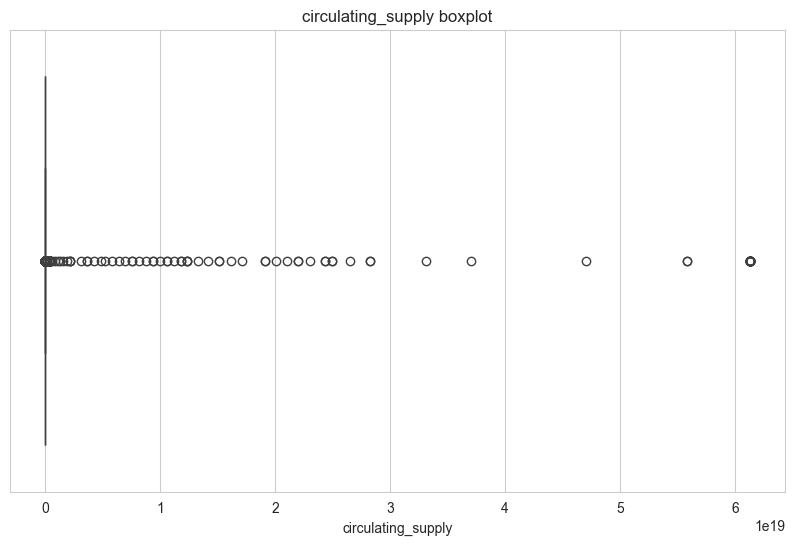

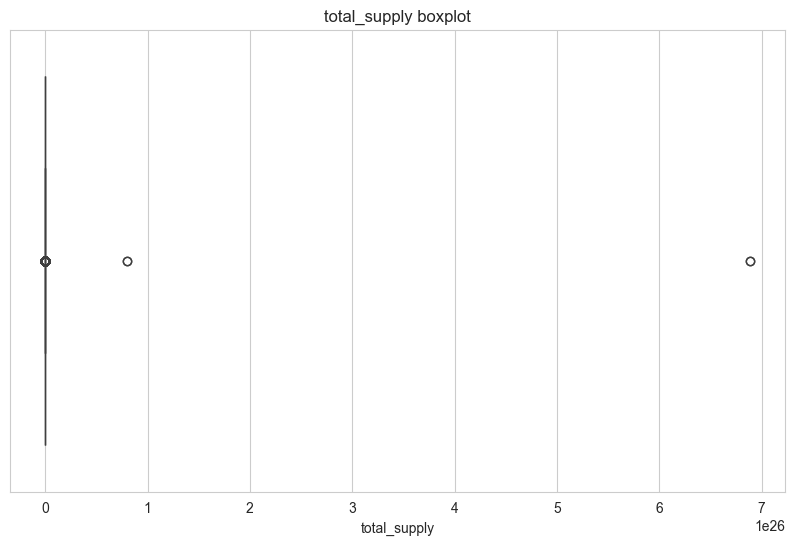

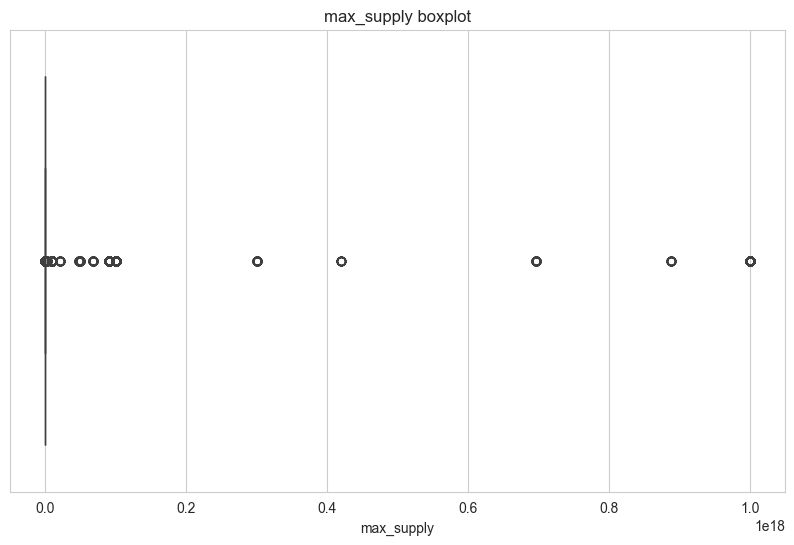

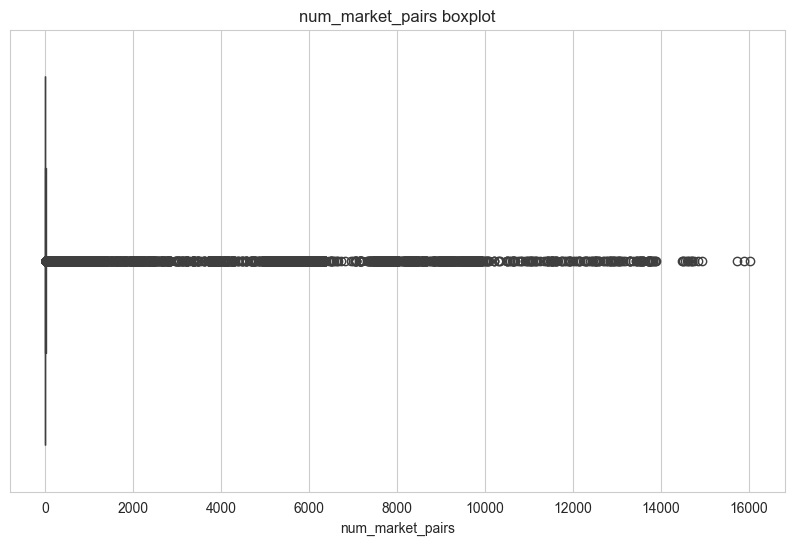

In [7]:
for col in num_cols:
    sns.boxplot(x=historical[col]); plt.title(f"{col} boxplot")
    plt.show()

## 6. Correlation Heatmap
Check correlations among numeric features in `historical`.

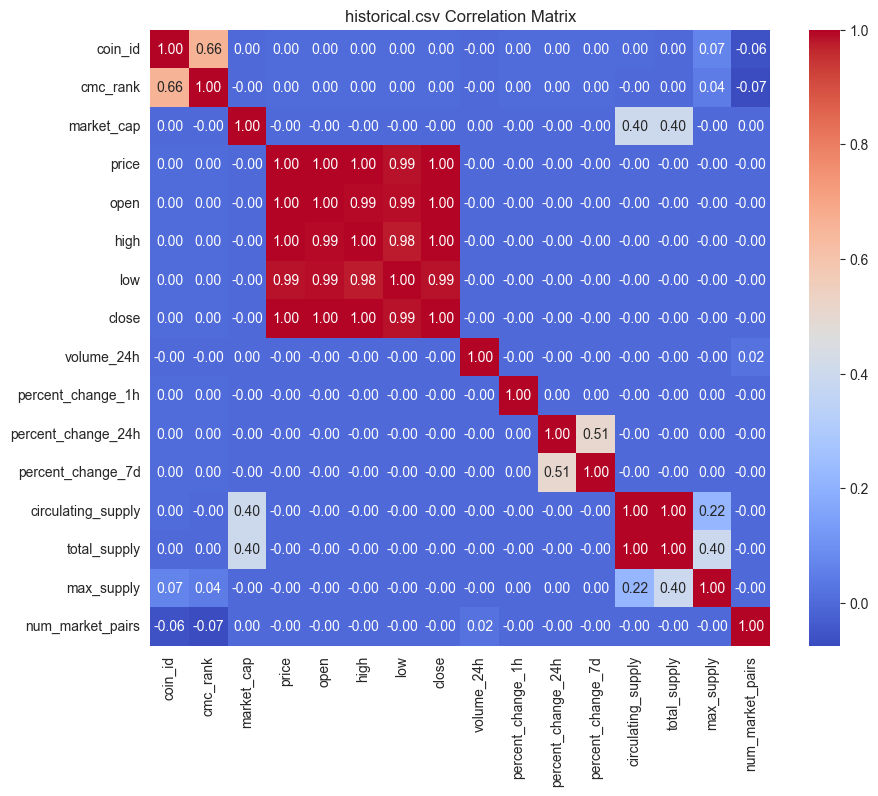

In [8]:
corr = historical[num_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("historical.csv Correlation Matrix")
plt.show()

## 7. Time-Series Trends
Plot `price` and `market_cap` over time.

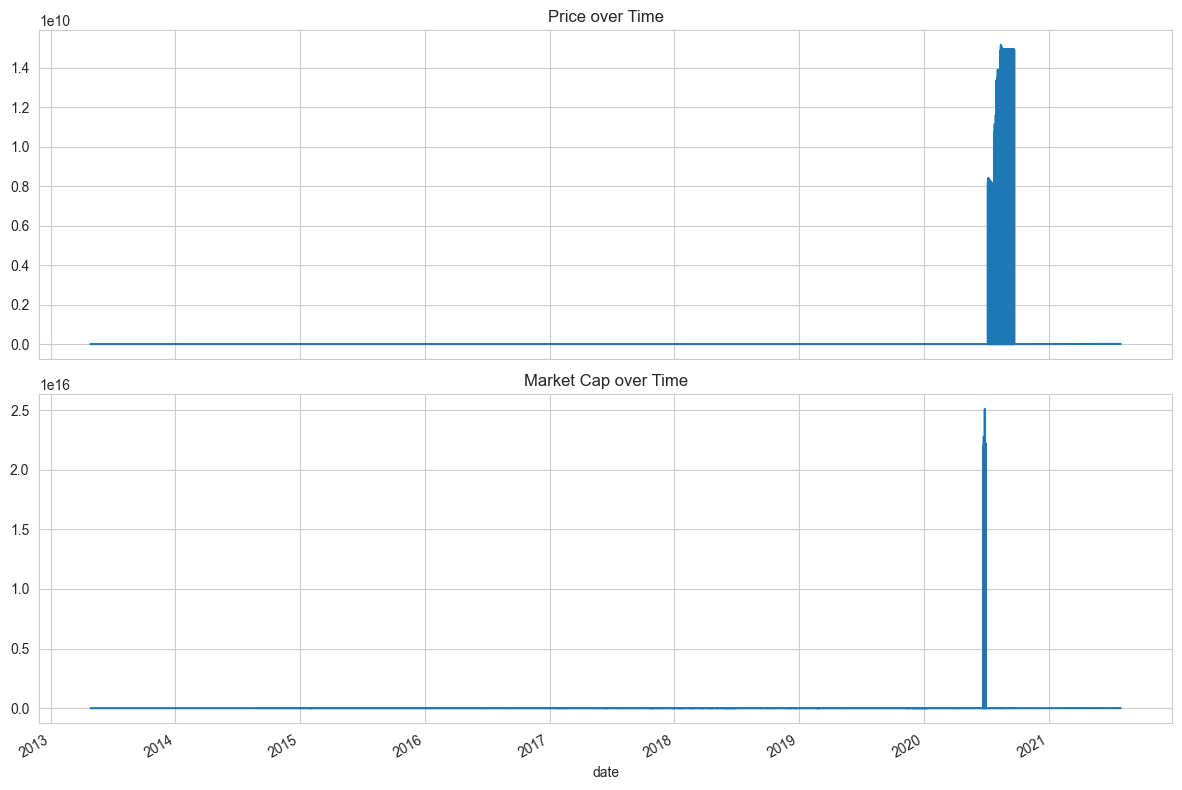

In [9]:
historical['date'] = pd.to_datetime(historical['date'])
fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)
historical.set_index('date')['price'].plot(ax=ax[0], title="Price over Time")
historical.set_index('date')['market_cap'].plot(ax=ax[1], title="Market Cap over Time")
plt.tight_layout()
plt.show()

## 8. Sentiment Time-Series
Plot `count` and `normalized` for each sentiment DataFrame.

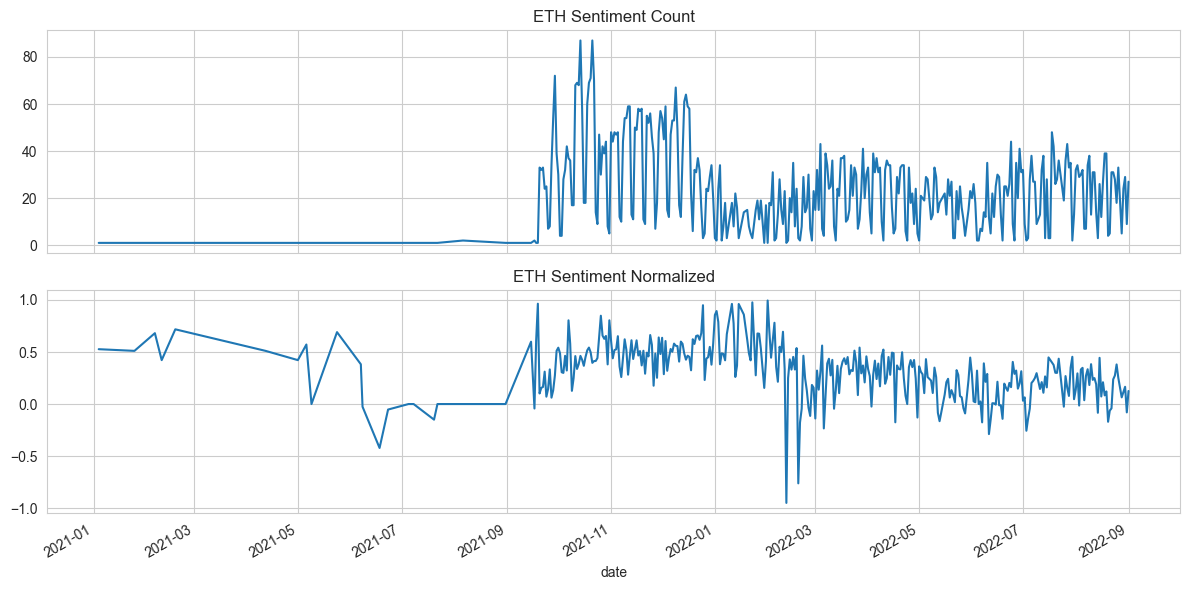

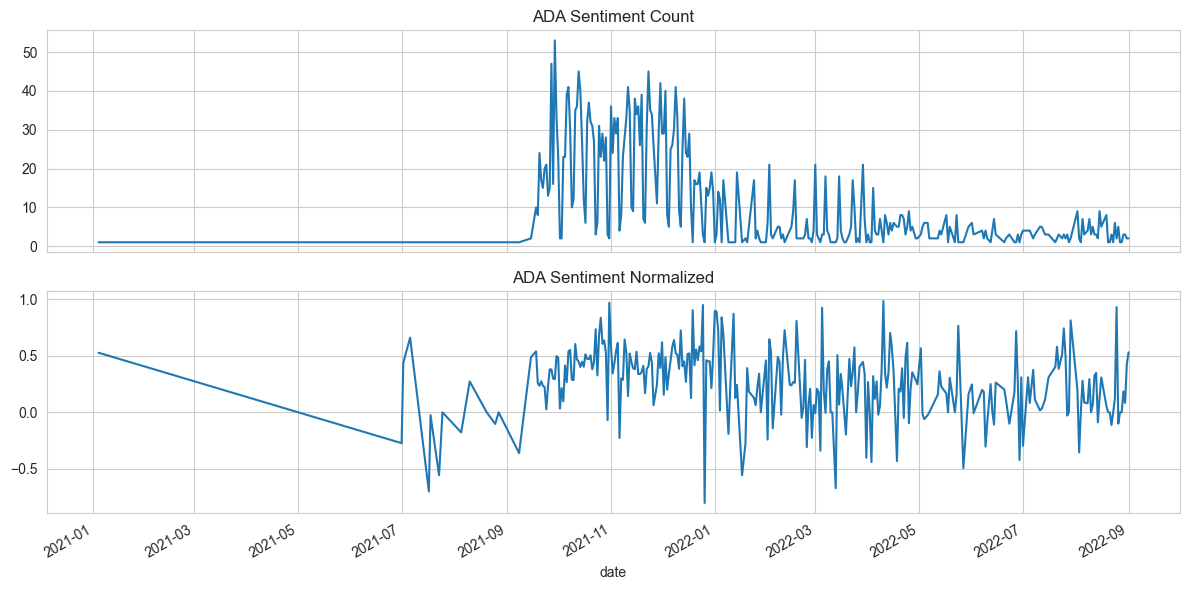

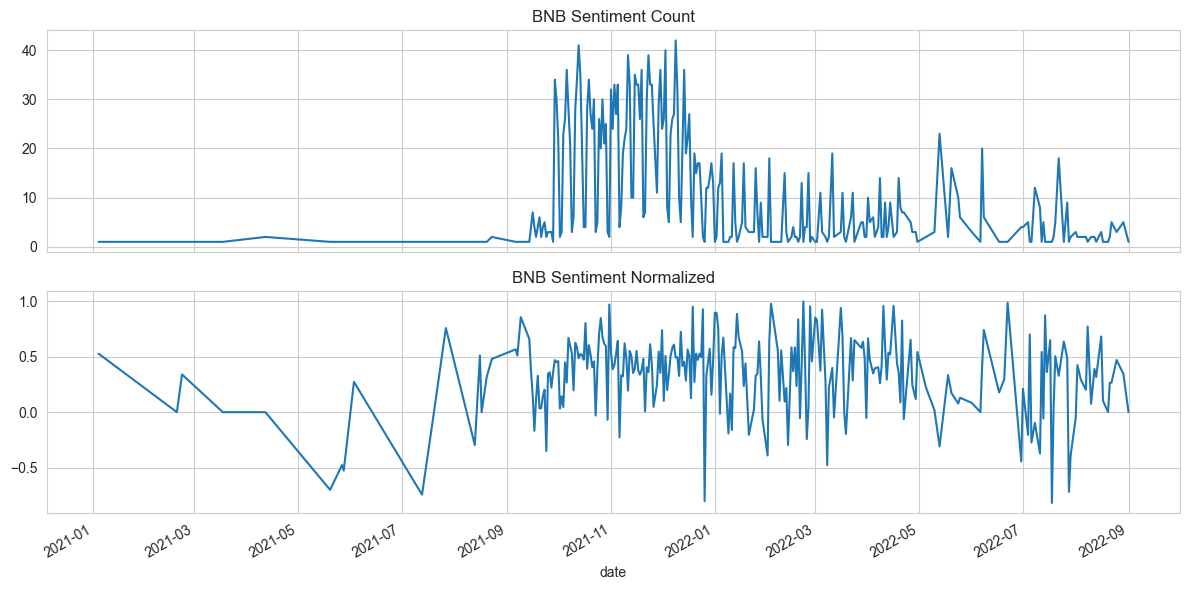

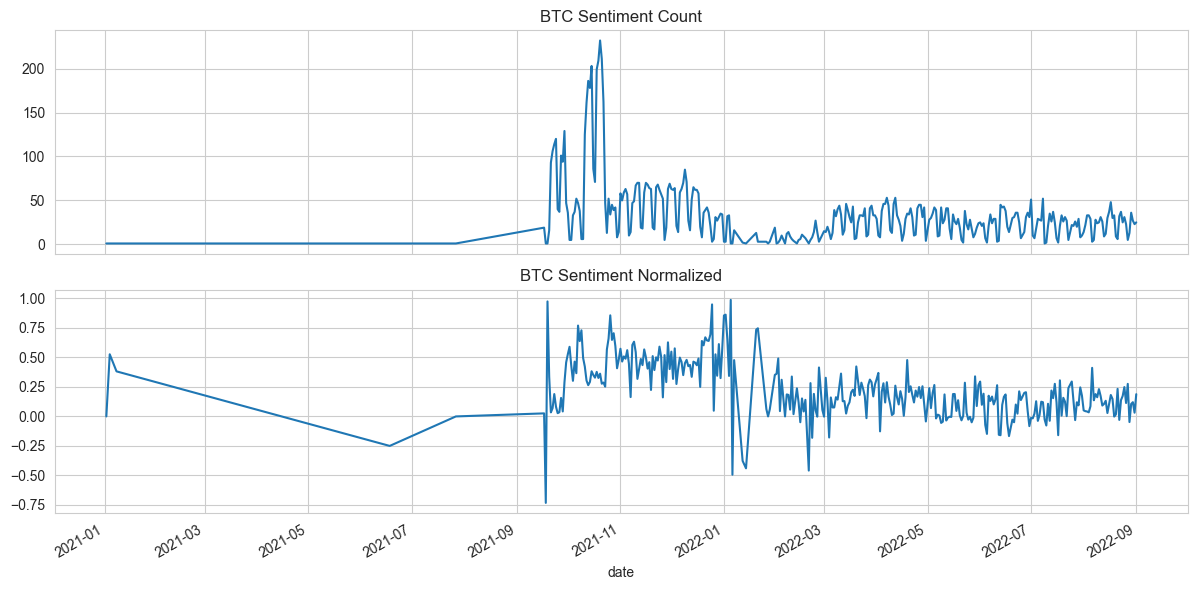

In [10]:
for name, df in [("ETH", eth_df), ("ADA", ada_df), ("BNB", bnb_df), ("BTC", btc_df)]:
    df['date'] = pd.to_datetime(df['date'])
    fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
    df.set_index('date')['count'].plot(ax=ax[0], title=f"{name} Sentiment Count")
    df.set_index('date')['normalized'].plot(ax=ax[1], title=f"{name} Sentiment Normalized")
    plt.tight_layout()
    plt.show()

## 9. Save Interim Cleaned Data
After making your imputation/outlier decisions, save for Phase 2.

In [ ]:
# (Apply your cleaning steps here, e.g. interpolation, capping)
historical_clean = historical.copy()  
coins_clean      = coins.copy()

historical_clean.to_csv(f"{DATA_INTERIM}/historical_clean.csv", index=False)
coins_clean.to_csv(f"{DATA_INTERIM}/coins_clean.csv", index=False)